In [1]:
import numpy as np
import pandas as pd 
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.linear_model import LinearRegression, Lasso
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import cross_val_score
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.ensemble import VotingRegressor



/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
train = pd.read_csv('/kaggle/input/playground-series-s3e14/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s3e14/test.csv')

# EDA

My previous notebook, https://www.kaggle.com/code/irda22/ps-s3e14-quick-eda-outliers-baseline-rf, already performed a quick exploratory data analysis (EDA), so we will use that information directly and focus on implementing different neural networks and the stacking technique.

# Data Preprocessing

In [3]:
corr_matrix = train.corr().abs()

# Drop TRange columns
trange_cols = [col for col in train.columns if col.endswith('TRange')]
max_corr = corr_matrix.loc[trange_cols, 'yield'].max()
best_trange_col = corr_matrix.loc[trange_cols, 'yield'][corr_matrix.loc[trange_cols, 'yield'] == max_corr].index[0]
trange_cols.remove(best_trange_col)
train.drop(trange_cols, axis=1, inplace=True)

#Drop rain column
target_corr = corr_matrix['yield']
if target_corr['RainingDays'] < target_corr['AverageRainingDays']:
    rain_col = 'RainingDays'
else:
    rain_col = 'AverageRainingDays'
train.drop(rain_col, axis=1, inplace=True)

In [4]:
# Scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(train.drop(['id','yield'], axis = 1))
y_train = train['yield']

In [5]:
# Preprocess data
test.drop(trange_cols, axis=1, inplace=True)
test.drop(rain_col, axis=1, inplace=True)

# Scale the data
X_test = scaler.transform(test.drop(['id'], axis = 1))

# Neural network stacking

To perform the stacking technique, we will define five models with different architectures to introduce diversity. We will train each model on a different subset of the training data to reduce the risk of overfitting. The goal is to have the models learn different patterns in the data and make diverse predictions. We will then stack the predictions of these models using a neural network with a simple architecture. The neural network will aggregate the predictions and give the final prediction, hopefully resulting in a better-performing model than any individual model.

In [6]:
# 5 NN architectures defined based on experimentation

models = [
    keras.Sequential([
            layers.Dense(512, activation='selu', input_shape = [X_train.shape[1]]),
            layers.Dense(256, activation='selu'),
            layers.Dense(128, activation='selu'),
            layers.Dense(64, activation='selu'),
            layers.Dense(32, activation='selu'),
            layers.Dense(1, activation='linear')
        ]),
    keras.Sequential([
            layers.Dense(512, activation='relu', input_shape = [X_train.shape[1]]),
            layers.Dense(256, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dense(64, activation='relu'),
            layers.Dense(32, activation='relu'),
            layers.Dense(1, activation='linear')
        ]),
    keras.Sequential([
            layers.Dense(512, activation='relu', input_shape = [X_train.shape[1]]),
            layers.Dense(256, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dense(32, activation='relu'),
            layers.Dense(1, activation='linear')
        ]),
    keras.Sequential([
            layers.Dense(256, activation='relu', input_shape = [X_train.shape[1]]),
            layers.Dense(64, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dense(32, activation='relu'),
            layers.Dense(1, activation='linear')
        ]),
    keras.Sequential([
            layers.Dense(256, activation='elu', input_shape = [X_train.shape[1]]),
            layers.Dense(64, activation='elu'),
            layers.Dense(128, activation='elu'),
            layers.Dense(32, activation='elu'),
            layers.Dense(1, activation='linear')
        ]),
]



In [7]:
early_stop = EarlyStopping(monitor='loss', min_delta = 0.5, patience=15,restore_best_weights=True)

num_folds = 5

kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Each model is trained on a different subset of the data
for fold_idx, (train_idx, test_idx) in enumerate(kf.split(X_train)):
    
    # Get the training and testing data for the fold
    X_train_fold = X_train[train_idx]
    y_train_fold = y_train[train_idx]
    X_test_fold = X_train[test_idx]
    y_test_fold = y_train[test_idx]    
    
    # Train the model on the current fold
    print(f'MODEL {fold_idx}')
    model = models[fold_idx]
    model.compile(loss='mean_absolute_error', optimizer='adam')
    model.fit(X_train_fold, y_train_fold, batch_size = 64, epochs = 100, verbose = 1, callbacks=[early_stop])

MODEL 0
Epoch 1/100
192/192 [==============================] - 2s 6ms/step - loss: 2068.5090
Epoch 2/100
192/192 [==============================] - 1s 6ms/step - loss: 384.1516
Epoch 3/100
192/192 [==============================] - 1s 5ms/step - loss: 384.7827
Epoch 4/100
192/192 [==============================] - 1s 6ms/step - loss: 378.7703
Epoch 5/100
192/192 [==============================] - 1s 5ms/step - loss: 379.9022
Epoch 6/100
192/192 [==============================] - 1s 5ms/step - loss: 377.6606
Epoch 7/100
192/192 [==============================] - 1s 5ms/step - loss: 379.4056
Epoch 8/100
192/192 [==============================] - 1s 5ms/step - loss: 374.2513
Epoch 9/100
192/192 [==============================] - 1s 5ms/step - loss: 371.9796
Epoch 10/100
192/192 [==============================] - 1s 5ms/step - loss: 375.6918
Epoch 11/100
192/192 [==============================] - 1s 5ms/step - loss: 373.1583
Epoch 12/100
192/192 [==============================] - 1s 5ms/st

In [8]:
# Make predictions on the train set with each model
predictions = []
for model in models:
    predictions.append(model.predict(X_train))
predictions = np.array(predictions)

# Prepare data to feed the meta model
X_predictions = np.array([predictions[:,i] for i in range(len(predictions[0]))])
X_train_preds = np.reshape(X_predictions, (X_predictions.shape[0], X_predictions.shape[1]))


478/478 [==============================] - 1s 1ms/step


In [9]:
early_stop = EarlyStopping(monitor='loss', min_delta = 0.5, patience=25,restore_best_weights=True)

# Simple NN architecture for meta model
meta_model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape = [X_predictions.shape[1]]),
        layers.Dense(8, activation='relu'),
        layers.Dense(1)
    ])

meta_model.compile(loss='mae', optimizer='adam')
meta_model.fit(X_train_preds, y_train, batch_size=32, epochs = 100, verbose=1, callbacks=[early_stop])

Epoch 1/100
478/478 [==============================] - 1s 2ms/step - loss: 617.2661
Epoch 2/100
478/478 [==============================] - 1s 2ms/step - loss: 354.9177
Epoch 3/100
478/478 [==============================] - 1s 2ms/step - loss: 354.8636
Epoch 4/100
478/478 [==============================] - 1s 2ms/step - loss: 355.9483
Epoch 5/100
478/478 [==============================] - 1s 2ms/step - loss: 352.9344
Epoch 6/100
478/478 [==============================] - 1s 2ms/step - loss: 353.9115
Epoch 7/100
478/478 [==============================] - 1s 2ms/step - loss: 355.3878
Epoch 8/100
478/478 [==============================] - 1s 2ms/step - loss: 354.0639
Epoch 9/100
478/478 [==============================] - 1s 2ms/step - loss: 351.6067
Epoch 10/100
478/478 [==============================] - 1s 2ms/step - loss: 353.2030
Epoch 11/100
478/478 [==============================] - 1s 2ms/step - loss: 352.5422
Epoch 12/100
478/478 [==============================] - 1s 2ms/step - loss

478/478 [==============================] - 1s 1ms/step


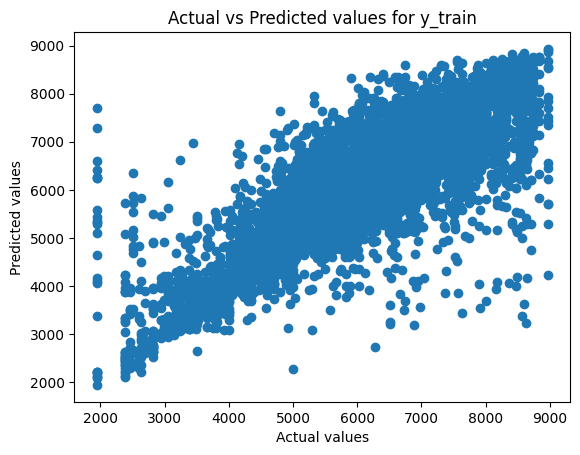

In [10]:
y_train_pred = meta_model.predict(X_predictions)

# plot the actual versus predicted values
plt.scatter(y_train, y_train_pred)
plt.xlabel("Actual values")
plt.ylabel("Predicted values")
plt.title("Actual vs Predicted values for y_train")
plt.show()

# Predictions

In [11]:
predictions = []
for model in models:
    predictions.append(model.predict(X_test))
predictions = np.array(predictions)
X_predictions = np.array([predictions[:,i] for i in range(len(predictions[0]))])
X_predictions = np.reshape(X_predictions, (X_predictions.shape[0], X_predictions.shape[1]))
y_pred = meta_model.predict(X_predictions)
y_pred = np.reshape(y_pred, (y_pred.shape[0]))
submission_df = pd.DataFrame({'id': test['id'], 'yield': y_pred})
submission_df.to_csv('submission.csv', index=False)

319/319 [==============================] - 0s 1ms/step
